# Biharmonic Equation with nonlienar Discointinuities

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from tqdm import tqdm

In [2]:
from IPython.display import clear_output, Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(f'Using {device}')

Using cuda


In [5]:
class PINN_2D(nn.Module):
    def __init__(self):
        super(PINN_2D, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, xy):
        return self.layers(xy)

In [6]:
def q_function(u):
    q_u = u**3
    return q_u

In [7]:
# # Bi-laplacian
def compute_bilaplacian(u, xy):
    grad_u = torch.autograd.grad(u.sum(), xy, create_graph=True)[0]
    grad_u_x = grad_u[:, 0]
    grad_u_y = grad_u[:, 1]
    grad_u_xx = torch.autograd.grad(grad_u_x.sum(), xy, create_graph=True)[0][:, 0]
    grad_u_yy = torch.autograd.grad(grad_u_y.sum(), xy, create_graph=True)[0][:, 1]
    bilaplacian = grad_u_xx + grad_u_yy
    return bilaplacian

In [8]:
# Normal Derivative in the Circle
def compute_normal_derivative(u, xy, tolerance=1e-3):
    x, y = xy[:, 0], xy[:, 1]
    radius = torch.sqrt(x**2 + y**2)
    on_boundary = torch.abs(radius - 1) < tolerance
    grad_u = torch.autograd.grad(u.sum(), xy, create_graph=True)[0]
    tangent_vector = torch.stack([-y, x], dim=1)
    normal_derivative = (grad_u * tangent_vector).sum(dim=1)
    normal_derivative[~on_boundary] = 0
    return normal_derivative

In [9]:
# def compute_normal_derivative(u, xy, tolerance=1e-3):
#     x, y = xy[:, 0], xy[:, 1]
#     on_boundary = (torch.abs(x - 1) < tolerance) | (torch.abs(x + 1) < tolerance) | (torch.abs(y - 1) < tolerance) | (torch.abs(y + 1) < tolerance)
#     grad_u = torch.autograd.grad(u.sum(), xy, create_graph=True)[0]
#     normal_derivative = torch.zeros_like(x)
    
#     # Normal derivatives for the four sides of the square
#     normal_derivative[torch.abs(x - 1) < tolerance] = grad_u[torch.abs(x - 1) < tolerance, 0]  # Right side
#     normal_derivative[torch.abs(x + 1) < tolerance] = -grad_u[torch.abs(x + 1) < tolerance, 0] # Left side
#     normal_derivative[torch.abs(y - 1) < tolerance] = grad_u[torch.abs(y - 1) < tolerance, 1]  # Top side
#     normal_derivative[torch.abs(y + 1) < tolerance] = -grad_u[torch.abs(y + 1) < tolerance, 1] # Bottom side
    
#     normal_derivative[~on_boundary] = 0
#     return normal_derivative

In [10]:
# Loss Function
def loss_function(pinn, xy, boundary_points, a, beta):
    u_pred = pinn(xy)
    H_approx = 1 / (1 + torch.exp(-beta * (u_pred - a)))
    q_u = q_function(u_pred)
    u_xx = compute_bilaplacian(u_pred, xy)
    loss_edp = torch.mean((u_xx - H_approx * q_u)**2)
    u_boundary = pinn(boundary_points)
    u_normal_derivative_boundary = compute_normal_derivative(u_boundary, boundary_points)
    loss_boundary = torch.mean(u_boundary**2) + torch.mean(u_normal_derivative_boundary**2)
    # return loss_edp + loss_boundary
    loss_total = loss_edp + loss_boundary
    return loss_total, loss_edp, loss_boundary

In [11]:
# Parameters
a = 0.5
beta = 10
epochs = 200

In [12]:
# xy_points = torch.tensor(np.random.uniform(-1, 1, (1000, 2)), dtype=torch.float32)
# boundary_points = xy_points[torch.sqrt(xy_points[:, 0]**2 + xy_points[:, 1]**2) > 0.95]
# xy_points = xy_points.to(device)
# boundary_points = boundary_points.to(device)

In [13]:
pinn_2d = PINN_2D().to(device)

In [14]:
pinn_2d

PINN_2D(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adam(pinn_2d.parameters(), lr=0.01)

Epoch 2/200 [                                                 ] Total Loss: 0.01747295819222927 EDP Loss: 0.00622492516413331 Boundary Loss: 0.011248033493757248361

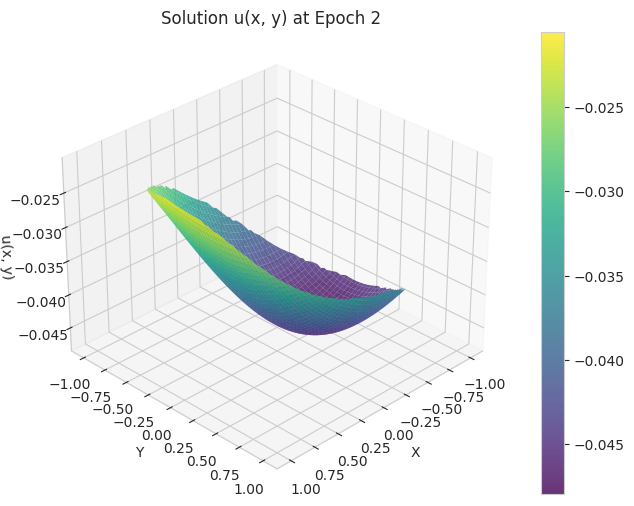

Epoch 12/200 [==                                               ] Total Loss: 0.0008206218481063843 EDP Loss: 3.39112630172167e-05 Boundary Loss: 0.000786710588727146435

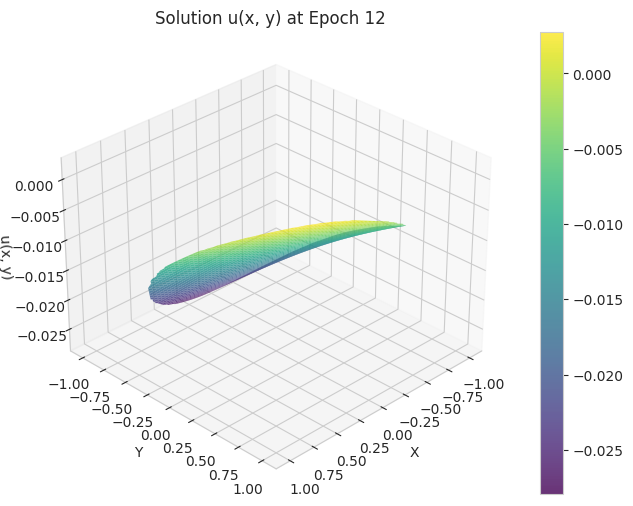

Epoch 22/200 [=====                                            ] Total Loss: 7.252656359924003e-05 EDP Loss: 1.3740756912739016e-05 Boundary Loss: 5.8785804867511615e-054

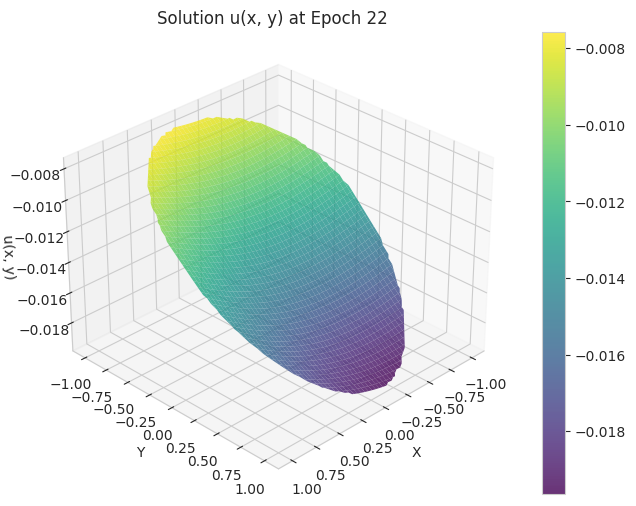

Epoch 32/200 [=======                                          ] Total Loss: 8.648195216665044e-05 EDP Loss: 3.6290059597376967e-06 Boundary Loss: 8.285294461529702e-0553

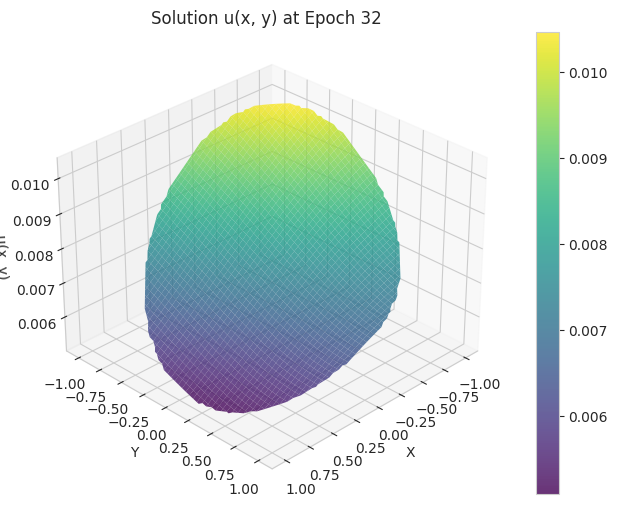

Epoch 42/200 [==========                                       ] Total Loss: 1.3623382074001711e-05 EDP Loss: 2.0706229406641796e-06 Boundary Loss: 1.1552759133337531e-05

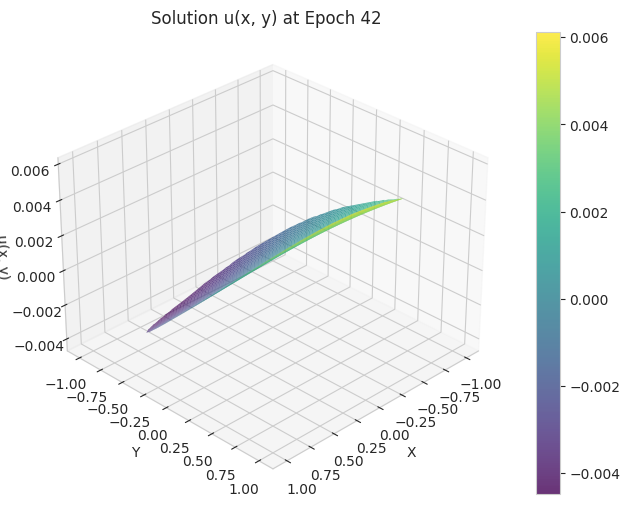

Epoch 52/200 [============                                     ] Total Loss: 8.50911146699218e-06 EDP Loss: 1.3333753940969473e-06 Boundary Loss: 7.175736300268909e-06605

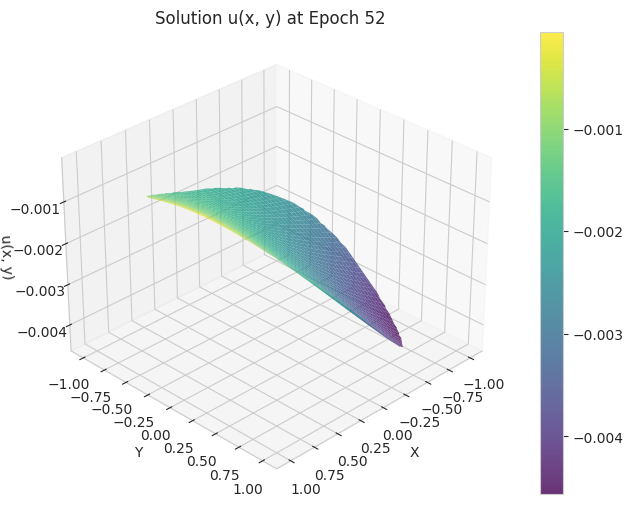

Epoch 62/200 [===============                                  ] Total Loss: 2.2626222744293045e-06 EDP Loss: 7.612953254465538e-07 Boundary Loss: 1.5013270058261696e-06

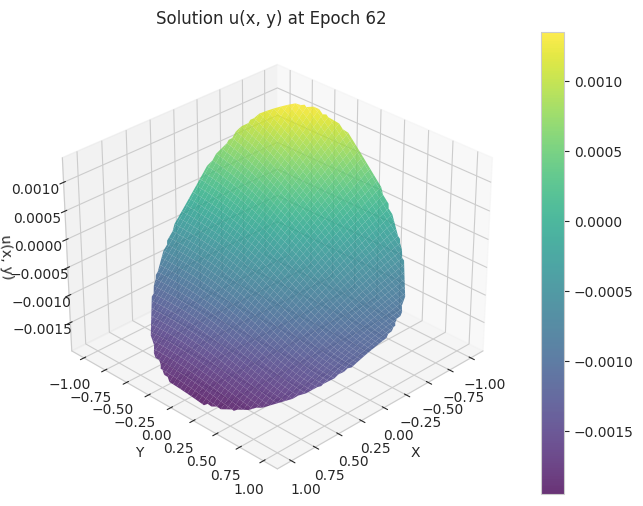

Epoch 72/200 [=================                                ] Total Loss: 1.607115564183914e-06 EDP Loss: 2.43481906636589e-07 Boundary Loss: 1.3636336007039063e-0666

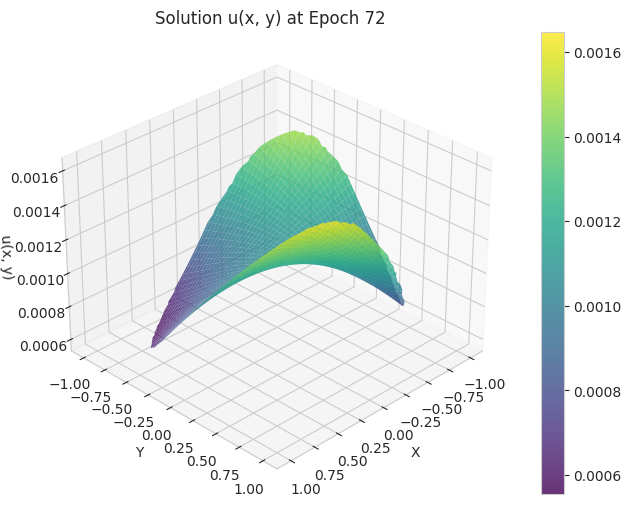

Epoch 82/200 [====================                             ] Total Loss: 4.4970130375077133e-07 EDP Loss: 2.0208894113693532e-07 Boundary Loss: 2.4761237682469073e-07

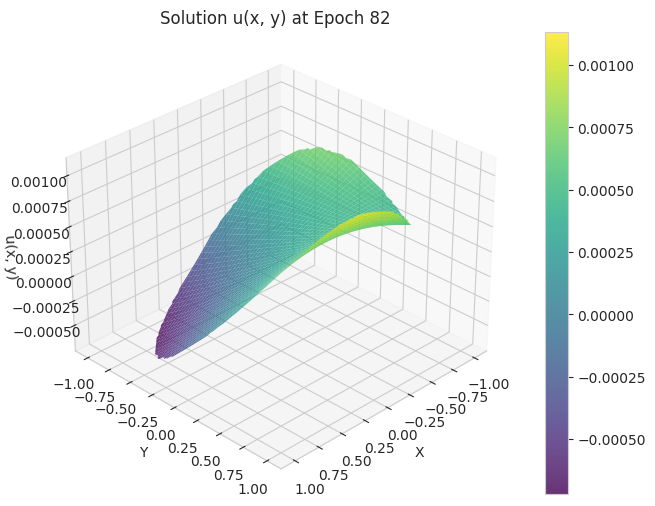

Epoch 92/200 [======================                           ] Total Loss: 3.6752339838130865e-07 EDP Loss: 1.949252634858567e-07 Boundary Loss: 1.7259813489545195e-077

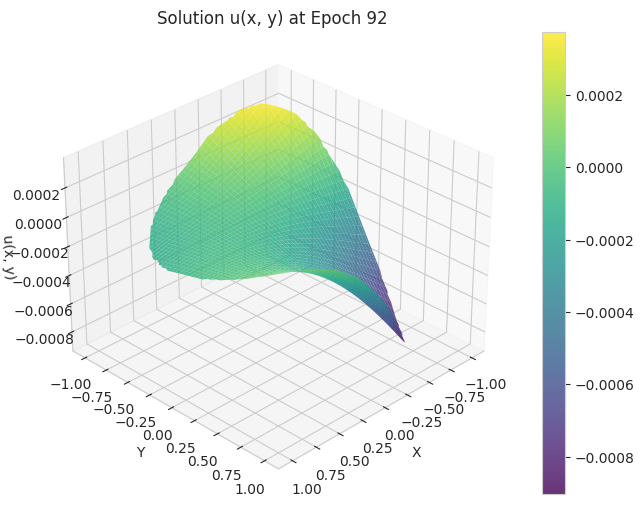

Epoch 102/200 [=========================                        ] Total Loss: 2.5112706225627335e-07 EDP Loss: 9.910179699090804e-08 Boundary Loss: 1.5202527947622002e-07

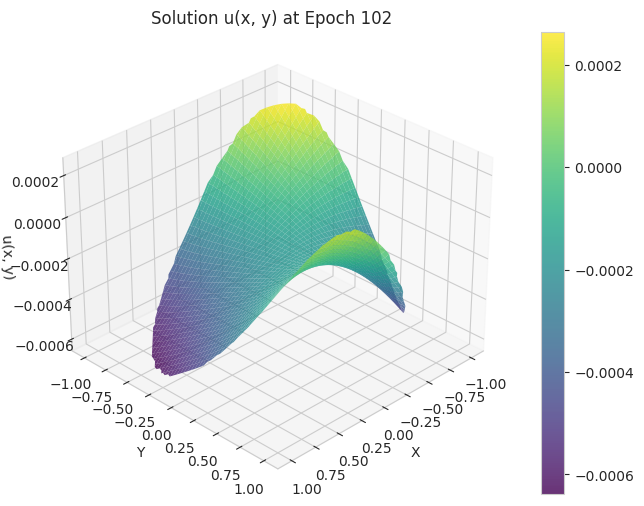

Epoch 112/200 [===========================                      ] Total Loss: 1.8824707126441353e-07 EDP Loss: 9.623506969091977e-08 Boundary Loss: 9.201200157349376e-088

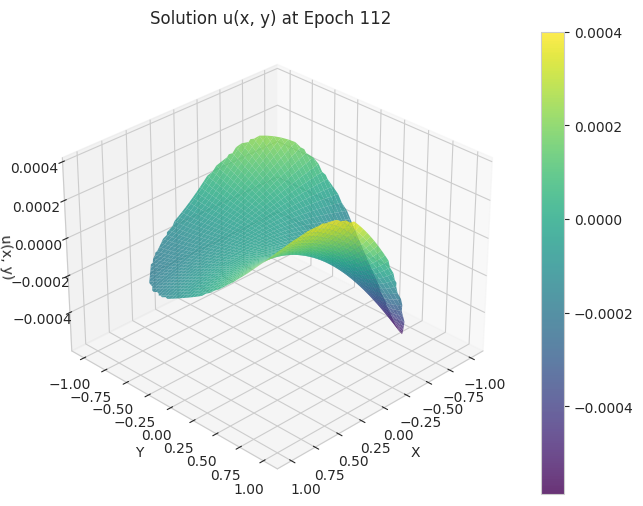

Epoch 122/200 [==============================                   ] Total Loss: 1.255612147588181e-07 EDP Loss: 6.583998413134395e-08 Boundary Loss: 5.972123062747414e-0888

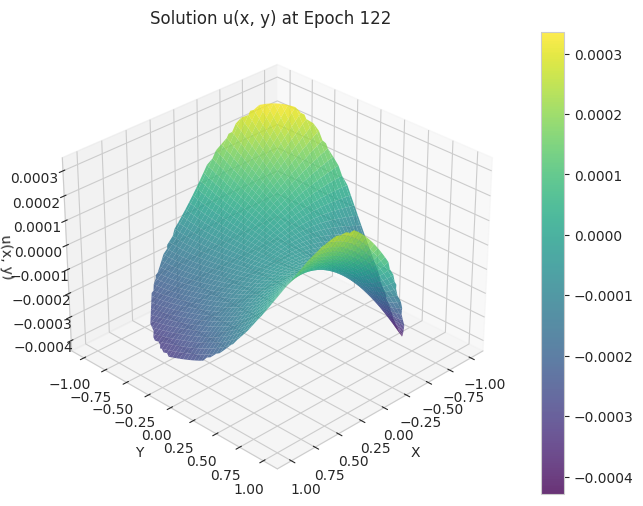

Epoch 132/200 [================================                 ] Total Loss: 1.0915921677678853e-07 EDP Loss: 6.353565851213716e-08 Boundary Loss: 4.5623558264651365e-08

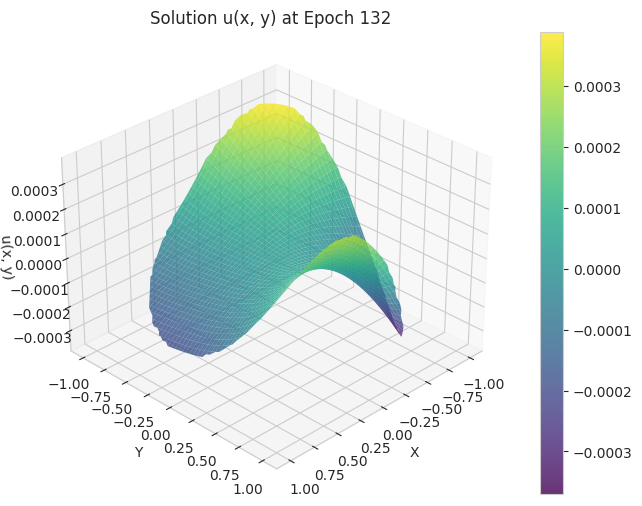

Epoch 142/200 [===================================              ] Total Loss: 1.1647723141550159e-07 EDP Loss: 6.53884697499052e-08 Boundary Loss: 5.1088761665596394e-088

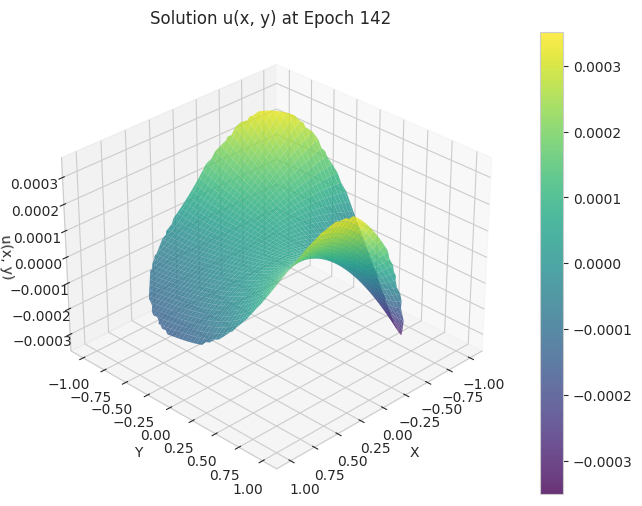

Epoch 152/200 [=====================================            ] Total Loss: 1.0996436117238773e-07 EDP Loss: 5.961424420775074e-08 Boundary Loss: 5.035011696463698e-088

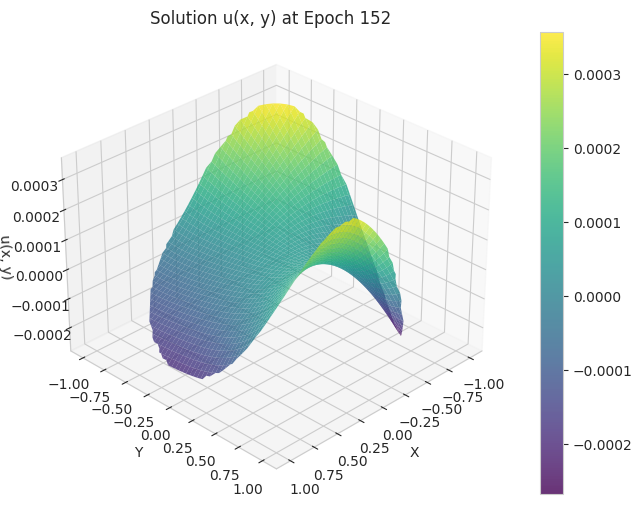

Epoch 162/200 [========================================         ] Total Loss: 9.757014396427621e-08 EDP Loss: 5.9094585225238916e-08 Boundary Loss: 3.8475558739037297e-08

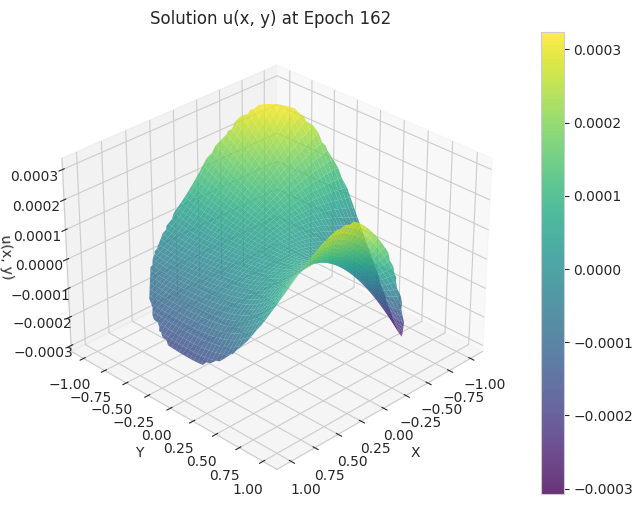

Epoch 172/200 [==========================================       ] Total Loss: 8.320004241113566e-08 EDP Loss: 5.262391411520184e-08 Boundary Loss: 3.057612829593381e-088

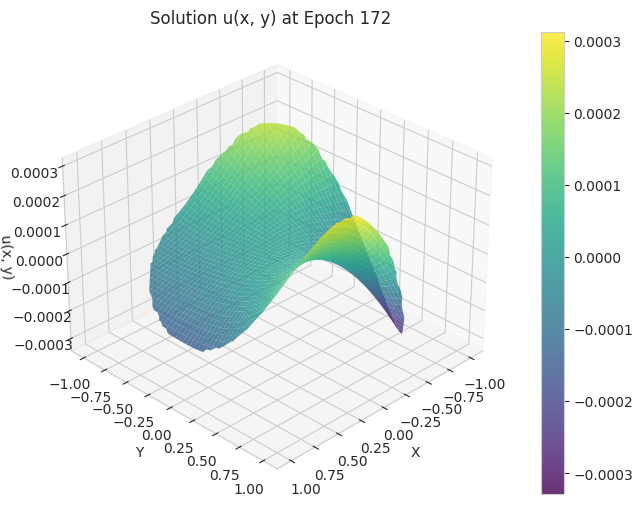

Epoch 182/200 [=============================================    ] Total Loss: 7.847879146538617e-08 EDP Loss: 4.824955723847779e-08 Boundary Loss: 3.0229230674194696e-088

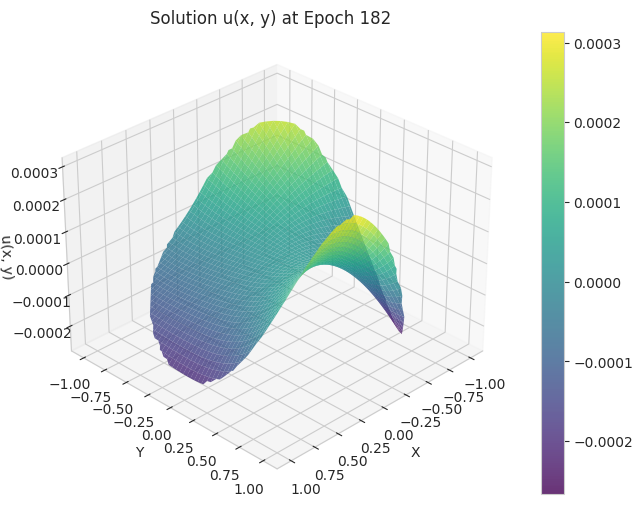

Epoch 192/200 [===============================================  ] Total Loss: 8.166217924099328e-08 EDP Loss: 5.2823796892198516e-08 Boundary Loss: 2.8838384125151606e-08

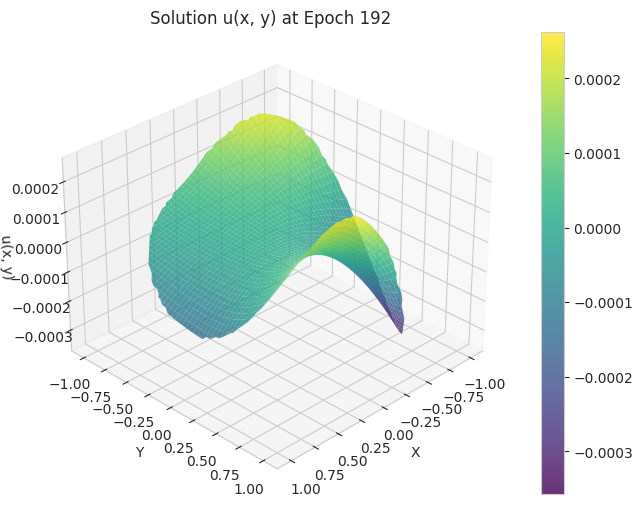

Epoch 200/200 [=================================================] Total Loss: 8.009826046873059e-08 EDP Loss: 4.794815922082307e-08 Boundary Loss: 3.2150101247907514e-088


In [16]:
losses = []
edp_losses = []
boundary_losses = []

for epoch in range(epochs):
        # Generando puntos aleatorios en cada época
    # Número de puntos
    num_points = 1000

    # Generar ángulos aleatorios entre 0 y 2*pi
    angles = 2 * np.pi * torch.rand(num_points)

    # Generar radios aleatorios entre 0 y 1
    radii = torch.sqrt(torch.rand(num_points))

    # Convertir coordenadas polares a cartesianas
    x = radii * torch.cos(angles)
    y = radii * torch.sin(angles)

    # Empaquetar las coordenadas x e y en una matriz
    xy_points_torch = torch.stack((x, y), dim=1).to(device)
    # Definir xy_points con requires_grad=True
    xy_points_torch.requires_grad = True

    xy_points_torch.requires_grad#, xy_points_torch[:5]

    
    # xy_points = torch.tensor(np.random.uniform(-1, 1, (1000, 2)), dtype=torch.float32, requires_grad=True).to(device)
    boundary_points = xy_points_torch[torch.sqrt(xy_points_torch[:, 0]**2 + xy_points_torch[:, 1]**2) > 0.95].to(device)

    optimizer.zero_grad()
    loss_total, loss_edp, loss_boundary = loss_function(pinn_2d, xy_points_torch, boundary_points, a, beta)
    loss_total.backward()
    optimizer.step()
    
    losses.append(loss_total.item())
    edp_losses.append(loss_edp.item())
    boundary_losses.append(loss_boundary.item())

    # Imprimiendo la barra de progreso y las métricas
    progress_bar = '=' * (epoch // (epochs // 50)) + ' ' * ((epochs - epoch - 1) // (epochs // 50))
    print(f"\rEpoch {epoch+1}/{epochs} [{progress_bar}] Total Loss: {loss_total.item()} EDP Loss: {loss_edp.item()} Boundary Loss: {loss_boundary.item()}", end="")
    
    if epoch % 10 == 1:
        # Visualización de la solución en intervalos regulares
        x_values, y_values = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
        mask = x_values**2 + y_values**2 > 1  # Máscara para puntos fuera del círculo

        xy_grid_flat = np.vstack([x_values.flatten(), y_values.flatten()]).T
        xy_grid_flat_tensor = torch.tensor(xy_grid_flat, dtype=torch.float32).to(device)
        u_values = pinn_2d(xy_grid_flat_tensor).detach().cpu().numpy().reshape(100, 100)
        u_values[mask] = np.nan  # Aplicar la máscara
        
        # # Grafico 1
        # sns.heatmap(u_values, cmap="viridis")
        # plt.title(f'Solution u(x, y) at Epoch {epoch+1}')
        # plt.show()
        
        # # Grafico 2
        # plt.contourf(x_values, y_values, u_values, levels=100, cmap="viridis")  # Dibuja la malla
        # plt.colorbar()  # Opcional: agrega una barra de colores
        # plt.axis('equal')  # Asegura que los ejes tengan la misma escala
        # plt.title(f'Solution u(x, y) at Epoch {epoch+1}')
        # plt.show()
        
        # # Grafico 3
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')
        # surf = ax.plot_surface(x_values, y_values, u_values, cmap="viridis", edgecolor='none')
        # ax.set_title(f'Solution u(x, y) at Epoch {epoch+1}')
        # fig.colorbar(surf)  # Opcional: agrega una barra de colores
        # plt.show()
        
        # Grafico 4
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(x_values, y_values, u_values, cmap="viridis", edgecolor='none', alpha=0.8)
        ax.view_init(elev=30, azim=45)  # Establecer la vista inicial
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('u(x, y)')
        ax.set_title(f'Solution u(x, y) at Epoch {epoch+1}')
        fig.colorbar(surf)  # Opcional: agrega una barra de colores
        plt.show()
        
print()  # Nueva línea al finalizar

In [17]:
# losses = []
# edp_losses = []
# boundary_losses = []
# images = []

# fig, ax = plt.subplots()

# for epoch in range(epochs):
#     # Generando puntos aleatorios en cada época
#     xy_points = torch.tensor(np.random.uniform(-1, 1, (1000, 2)), dtype=torch.float32, requires_grad=True).to(device)
#     boundary_points = xy_points[torch.sqrt(xy_points[:, 0]**2 + xy_points[:, 1]**2) > 0.95].to(device)

#     optimizer.zero_grad()
#     loss_total, loss_edp, loss_boundary = loss_function(pinn_2d, xy_points, boundary_points, a, beta)
#     loss_total.backward()
#     optimizer.step()
    
#     losses.append(loss_total.item())
#     edp_losses.append(loss_edp.item())
#     boundary_losses.append(loss_boundary.item())

#     # Imprimiendo la barra de progreso y las métricas
#     progress_bar = '=' * (epoch // (epochs // 50)) + ' ' * ((epochs - epoch - 1) // (epochs // 50))
#     print(f"\rEpoch {epoch+1}/{epochs} [{progress_bar}] Total Loss: {loss_total.item()} EDP Loss: {loss_edp.item()} Boundary Loss: {loss_boundary.item()}", end="")
    
    
#     # Visualización de la solución en cada época
#     xy_grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
#     xy_grid_flat = np.vstack([xy_grid[0].flatten(), xy_grid[1].flatten()]).T
#     xy_grid_flat_tensor = torch.tensor(xy_grid_flat, dtype=torch.float32).to(device)
#     u_values = pinn_2d(xy_grid_flat_tensor).detach().cpu().numpy().reshape(100, 100)
#     img = sns.heatmap(u_values, cmap="viridis", cbar=False, ax=ax)
#     ax.set_title(f'Solution u(x, y) at Epoch {epoch+1}')
#     images.append([img.get_children()[0]])  # Guardar el cuadro de la animación

#     # Mostrar la gráfica durante el entrenamiento cada 50 épocas
#     if epoch % 50 == 0 or epoch == 0:
#         plt.show()
#         # clear_output(wait=True)  # Limpiar la salida para la próxima gráfica

#     ax.clear()  # Limpiar el eje para la siguiente imagen

# print()  # Nueva línea al finalizar

# # Crear la animación
# ani = FuncAnimation(fig, lambda x: x[0], frames=images, interval=200)

# # Guardar la animación como un archivo GIF
# writer = PillowWriter(fps=20)
# ani.save('animation.gif', writer=writer)

In [18]:
# ani = FuncAnimation(fig, lambda x: x[0], frames=images, interval=200)
# plt.show()

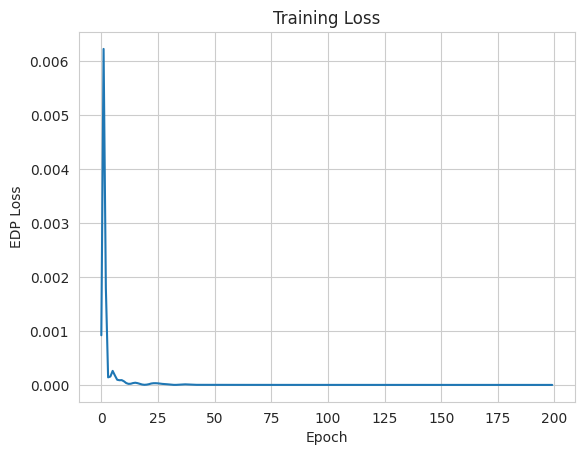

In [19]:
sns.lineplot(x=range(epochs), y=edp_losses)
plt.xlabel('Epoch')
plt.ylabel('EDP Loss')
plt.title('Training Loss')
plt.show()

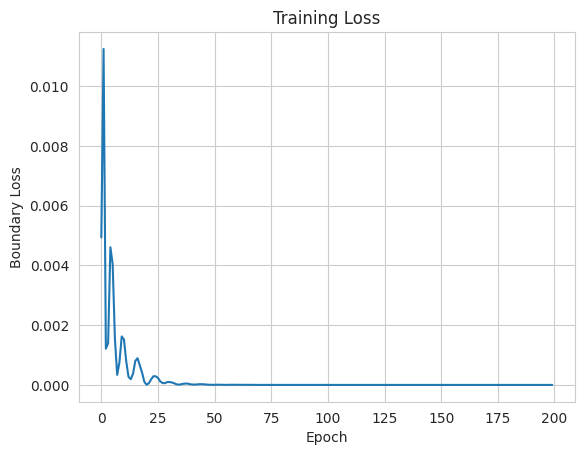

In [20]:
sns.lineplot(x=range(epochs), y=boundary_losses)
plt.xlabel('Epoch')
plt.ylabel('Boundary Loss')
plt.title('Training Loss')
plt.show()

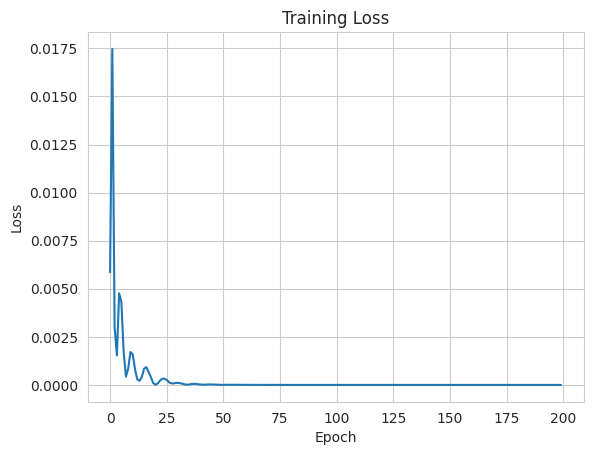

In [21]:
sns.lineplot(x=range(epochs), y=losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

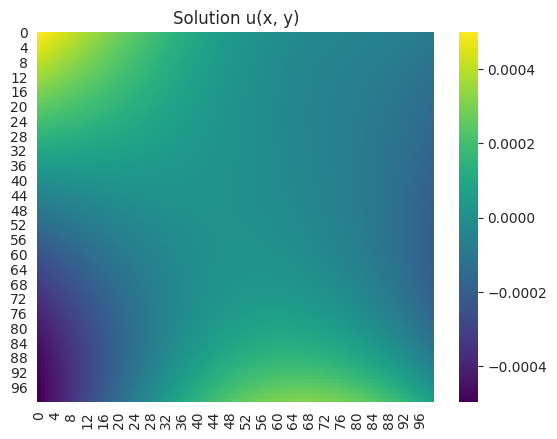

In [22]:
xy_grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
xy_grid_flat = np.vstack([xy_grid[0].flatten(), xy_grid[1].flatten()]).T
xy_grid_flat_tensor = torch.tensor(xy_grid_flat, dtype=torch.float32).to(device)
u_values = pinn_2d(xy_grid_flat_tensor).detach().cpu().numpy().reshape(100, 100)
sns.heatmap(u_values, cmap="viridis")
plt.title('Solution u(x, y)')
plt.show()